# Convolution in the Oilfield
**David S. Fulford**  
*October, 2018*  
*Updated February, 2020*

In this example, we'll use the [numpy.convolve](https://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html "Numpy reference for convolution") function to simplify the construction of a rigline profile. [Convolution](https://en.wikipedia.org/wiki/Convolution "Wikipedia") is a mathmetical operation that expresses how the shape of one function is modified by the other. We're interested in how the shape of our Production Profile is modified by a profile of well start dates or periods, so convolution makes a lot of sense to use in this case.

You can learn more background on convolution from [Khan Academy](https://www.khanacademy.org/math/differential-equations/laplace-transform/convolution-integral/v/introduction-to-the-convolution "Introduction to Convolution"), or from [Paul's Online Math Notes](http://tutorial.math.lamar.edu/Classes/DE/ConvolutionIntegrals.aspx "Convolution Integrals").

## <center> Convolution Illustration </center>
![Convolution Illustration](https://upload.wikimedia.org/wikipedia/commons/b/b9/Convolution_of_spiky_function_with_box2.gif)

#### Import the libraries we'll be using.

* [Numpy](http://www.numpy.org/) is one of the fundamental packages for Python that provides access to powerful functions for working with arrays.
* [Matplotlib](https://matplotlib.org/) is a simple and powerful library for plotting.
* [Sympy](https://www.sympy.org) is a symbolic math library.
* [Numba](https://numba.pydata.org/) is a just-in-time compiler that dynamically generates fast machine code from standard Python.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sympy as sym

#Default Settings
sym.init_printing(use_unicode=True, wrap_line=False)
%matplotlib inline

plt.style.use('seaborn-white')
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (12, 10)

### Convolution Examples

Let's start by illustrating some examples of the use of convolution. You've probably used it a lot more often than you think!

Convolution is used anytime we need to pass some constant "kernel" over another array of data. The simplest example I can think of is a moving average. In this case, our kernel looks like:

$$
\kappa = \begin{bmatrix}\frac{1}{5} \ \frac{1}{5} \ \frac{1}{5} \ \frac{1}{5} \ \frac{1}{5} \end{bmatrix}
$$

Or, just a set of constant weights that add up to one. This is "passed" over an array of data, and the sumproduct at each iteration is our result. 

How do we perform convolution? Well, numpy has a built-in function, `np.convolve`, but it requires adding a pad of zeroes to our array in order to prevent a circular convolution, and instead get a linear convolution. Circular convolution is common for signal analysis, but for time-series data it doesn't make much sense. Let's make our own convolution algorithm.

In [2]:
def conv(x: np.ndarray, k: np.ndarray) -> np.ndarray:
    # create an array of zeros to store our result
    result = np.zeros_like(x)
    b = len(k) - 1
    
    for i in range(len(x)):
        hi = min(b, i) # hi is the largest element of our kernel
        lo = max(0, i - b) # lo is the element corresponding to the smallest element of our kernel
        for j in range(i + 1):
            if hi - j < 0:
                break
            
            result[i] += x[lo + j] * k[hi - j]
            
    return result

OK, that's it! Pretty simple!

Let's make up some data.

In [3]:
x = np.linspace(0, 3, 2001)
y = np.random.rand(len(x))

And our kernel which will smooth over 50 elements.

In [4]:
k = np.full(50, 1.0 / 50.0)

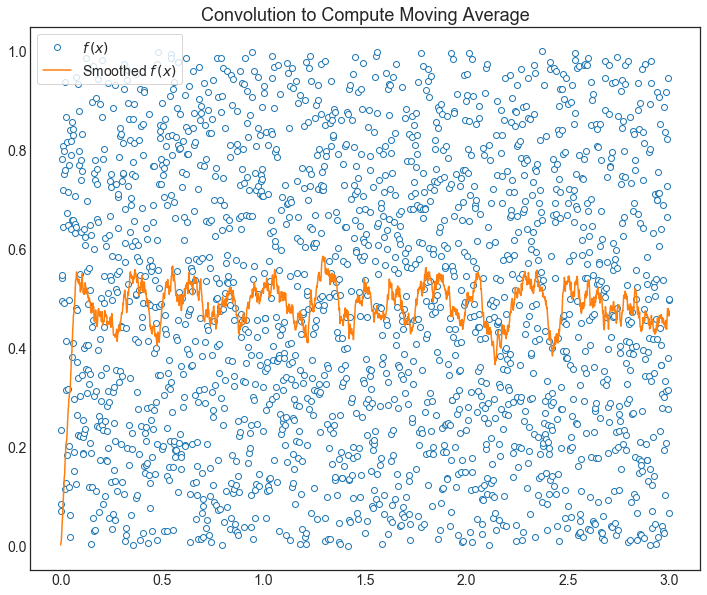

In [5]:
smooth_y = conv(y, k)

fig, ax = plt.subplots()

ax.plot(x, y, 'o', mfc='w', label='$f\,(x)$')
ax.plot(x, smooth_y, lw=1.5, label='Smoothed $f\,(x)$')

plt.title('Convolution to Compute Moving Average', fontsize=18)

ax.legend(loc='best', frameon=True)

plt.show()

Alright, that works. Let's compare against numpy, noting that we must first pad the array. We use `mode='same'` in order to ensure we get the same length output as we input.

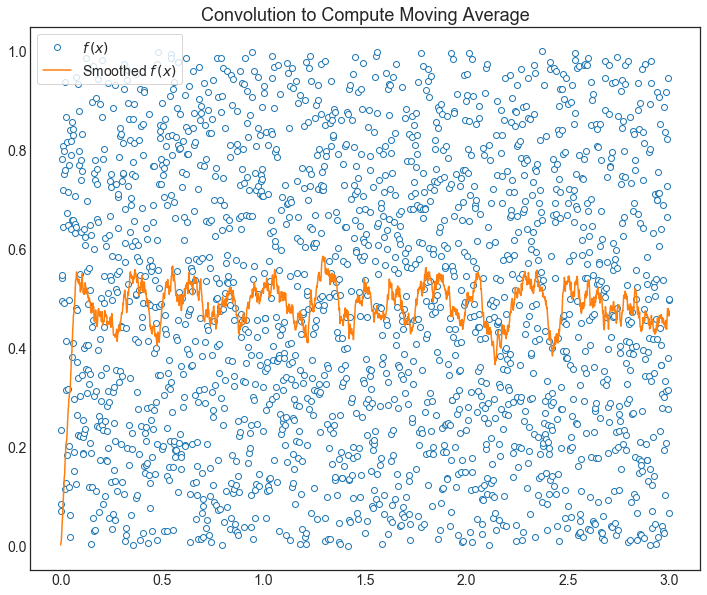

In [6]:
padded_k = np.r_[np.zeros(len(k) - 1), k]
smooth_y = np.convolve(y, padded_k, mode='same')

fig, ax = plt.subplots()

ax.plot(x, y, 'o', mfc='w', label='$f\,(x)$')
ax.plot(x, smooth_y, lw=1.5, label='Smoothed $f\,(x)$')

plt.title('Convolution to Compute Moving Average', fontsize=18)

ax.legend(loc='best', frameon=True)

plt.show()

Looks the same. Let's compare the performance of the Python algorithm versus `numpy`.

In [7]:
%timeit conv(x, k)

67.5 ms ± 962 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
%timeit np.convolve(x, padded_k)

74.3 µs ± 1.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


This is quite slow! There is a factor of >900x difference in speed!

Python is not a great language for numerical performance, which is why the `numpy` package is so useful for scientific computing as it is a wrapped around C or Fortran functions. However, sometime we want to implement our own algorithm for ease of use. `numba`, developed by Continuum Analytics (the makers of the `conda` package manager and `anaconda` Pytho distribution), allows just-in-time compilation of Python code using LLVM just by adding a simple decator in most cases.

In [22]:
from numba import jit

@jit
def conv(x: np.ndarray, k: np.ndarray) -> np.ndarray:
    # create an array of zeros to store our result
    result = np.zeros_like(x)
    b = len(k) - 1
    
    for i in range(len(x)):
        hi = min(b, i) # hi is the largest element of our kernel
        lo = max(0, i - b) # lo is the element corresponding to the smallest element of our kernel
        for j in range(i + 1):
            if hi - j < 0:
                break
            
            result[i] += x[max(0, i - b) + j] * k[min(b, i) - j]
            
    return result

In [23]:
%timeit conv(x, k)

183 µs ± 1.76 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


That's on the same order of magnitude as `numpy`! Of course, it's a bit simpler due to the fact that we do not need generate a padded array. 

The first time we call the function, `numba` will look at the types being passed, and compile a function. If types are added, we can ensure strong typing within Python, which is extremely useful to ensure accurate numerical calculations. Let's time our function again and check the performance.

### Smoothing Production Data

Smoothing noisy data can be very helpful to get a clear visual of production trend. In this case, let's load in 5000 days of daily gas production, make our kernel, and convolve.

In [11]:
data = np.genfromtxt('etx_well.csv', delimiter=',')[1:4750]
t, p, q = data[:, 0], data[:, 1], data[:, 2]

k = np.full(30, 1.0 / 30.0)
smooth_q = conv(q, k)

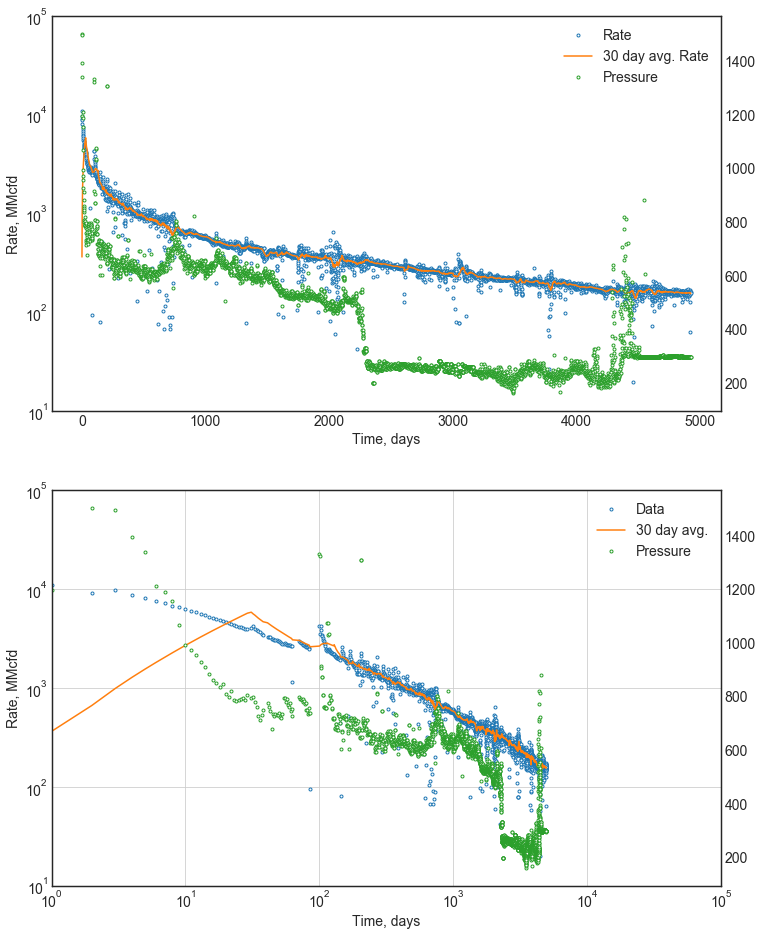

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(12, 16))

ax[0].plot(t, q, 'o', mfc='w', ms=3, label='Rate')
ax[0].plot(t, smooth_q, lw=1.5, label='30 day avg. Rate')
ax2 = ax[0].twinx()
ax2.plot(t, p, 'o', mfc='w', ms=3, c='C2', label='Pressure')

ax[0].set(yscale='log')
ax[0].set(ylabel='Rate, MMcfd', xlabel='Time, days', ylim=(1e1, 1e5))

h1, l1 = ax[0].get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend([*h1, *h2], [*l1, *l2], loc='upper right', ncol=1)

ax[1].plot(t, q, 'o', mfc='w', ms=3, label='Data')
ax[1].plot(t, smooth_q, lw=1.5, label='30 day avg.')
ax2 = ax[1].twinx()
ax2.plot(t, p, 'o', mfc='w', ms=3, c='C2', label='Pressure')

ax[1].set(yscale='log', xscale='log')
ax[1].set(ylabel='Rate, MMcfd', xlabel='Time, days', ylim=(1e1, 1e5), xlim=(1e0, 1e5))
# ax[1].set_aspect(1)
ax[1].grid(True)

h1, l1 = ax[1].get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend([*h1, *h2], [*l1, *l2], loc='upper right', ncol=1)

plt.show()

## Time-Rate-Pressure Forecasting

Convolution is also the basis for time-rate-pressure analysis. We can add pressure data, and even account for pressure in our forecasts, using our convolution algorithm. Let's write a simple hyperbolic function. We'll derive the full Arps identities below, but we'll keep it simple for now.

$$
q(t) = \frac{q_i}{(1 + D_i b \, t)^{{-1/}_b}}
$$

In [13]:
@jit
def hyp_rate(qi: float, Di: float, b: float, t: np.ndarray):
    Dnom = ((1 - Di) ** (-1 / b) - 1) / (b * 365.25)
    return qi / (1 + Dnom * b * t)

And the convolution identity for steps of constant flowing pressure is ([van Everdingen and Hurst, 1949](https://www.onepetro.org/journal-paper/SPE-949305-G)):

$$
q(t)= \frac{1}{\Delta p}\int_0^t q(\tau)\, \Delta p^\prime(t - \tau) \, d\tau
$$

Nothing special to do here, as our convolution algorithm already works for a linear convolution. Just specify an arbitrary initial pressure. An incorrect value does not impact our answer much as the derivative of $\Delta p$ means it only affects our very first data point.

In [14]:
forecast_t = np.arange(1, len(p)).astype(float)
forecast_q = hyp_rate(3800, .95, 1.5, forecast_t)

pi = 2000
dp = np.diff(pi - p, prepend=pi - p[0])
forecast_pq = 1 / 300 * conv(forecast_q, dp)

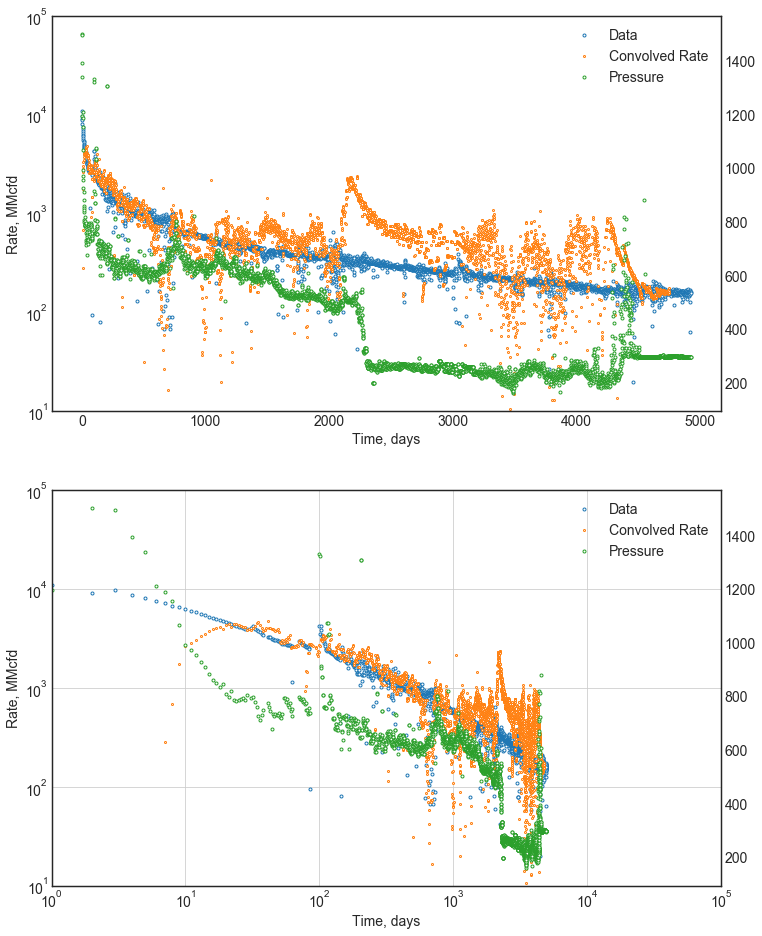

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(12, 16))

ax[0].plot(t, q, 'o', mfc='w', ms=3, label='Data')
ax[0].plot(forecast_t, forecast_pq, 'o', mfc='w', ms=2, lw=1.5,
           label='Convolved Rate')
ax2 = ax[0].twinx()
ax2.plot(t, p, 'o', mfc='w', ms=3, c='C2', label='Pressure')

ax[0].set(yscale='log')
ax[0].set(ylabel='Rate, MMcfd', xlabel='Time, days', ylim=(1e1, 1e5))

h1, l1 = ax[0].get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend([*h1, *h2], [*l1, *l2], loc='upper right', ncol=1)

ax[1].plot(t, q, 'o', mfc='w', ms=3, label='Data')
ax[1].plot(forecast_t, forecast_pq, 'o', mfc='w', ms=2, lw=1.5,
           label='Convolved Rate')
ax2 = ax[1].twinx()
ax2.plot(t, p, 'o', mfc='w', ms=3, c='C2', label='Pressure')

ax[1].set(yscale='log', xscale='log')
ax[1].set(ylabel='Rate, MMcfd', xlabel='Time, days', ylim=(1e1, 1e5), xlim=(1e0, 1e5))
# ax[1].set_aspect(1)
ax[1].grid(True)

h1, l1 = ax[1].get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend([*h1, *h2], [*l1, *l2], loc='upper right', ncol=1)

plt.show()

We can also generate a rate forecast given a pressure forecast.

In [16]:
p_extrapolate = p[-1] * np.exp((np.arange(t[-1] + 1, 10000) - t[-1]) * -.0002)
forecast_p = np.r_[p, p_extrapolate]
forecast_t_ext = np.arange(1, len(forecast_p) + 1).astype(float)
forecast_q_ext = hyp_rate(3800, .95, 1.5, forecast_t_ext)

dp = np.diff(pi - forecast_p, prepend=pi - forecast_p[0])
forecast_pq_ext = 1 / 300 * conv(forecast_q_ext, dp)

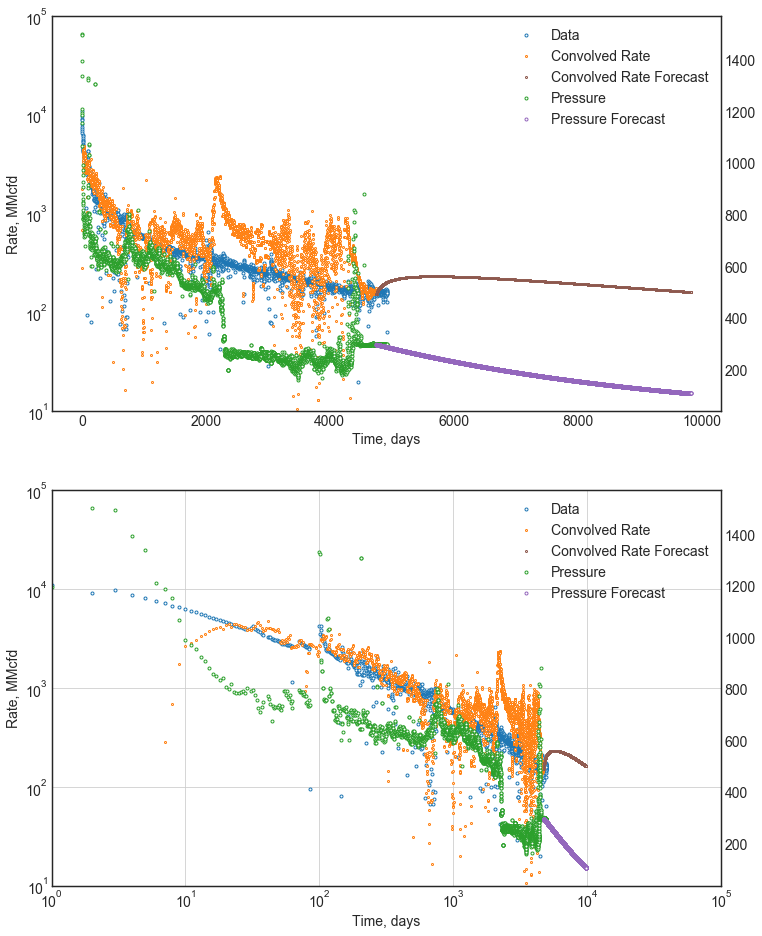

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(12, 16))

ax[0].plot(t, q, 'o', mfc='w', ms=3, label='Data')
ax[0].plot(forecast_t, forecast_pq, 'o', mfc='w', ms=2, lw=1.5, 
           label='Convolved Rate')
ax[0].plot(forecast_t_ext[4750:], forecast_pq_ext[4750:], 'o', c='C5', 
           mfc='w', ms=2, lw=1.5, label='Convolved Rate Forecast')
ax2 = ax[0].twinx()
ax2.plot(t, p, 'o', mfc='w', ms=3, c='C2', label='Pressure')
ax2.plot(forecast_t_ext[4750:], forecast_p[4750:], 'o', mfc='w', ms=3, c='C4',
         label='Pressure Forecast')

ax[0].set(yscale='log')
ax[0].set(ylabel='Rate, MMcfd', xlabel='Time, days', ylim=(1e1, 1e5))

h1, l1 = ax[0].get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend([*h1, *h2], [*l1, *l2], loc='upper right', ncol=1)

ax[1].plot(t, q, 'o', mfc='w', ms=3, label='Data')
ax[1].plot(forecast_t, forecast_pq, 'o', mfc='w', ms=2, lw=1.5,
           label='Convolved Rate')
ax[1].plot(forecast_t_ext[4750:], forecast_pq_ext[4750:], 'o', c='C5', 
           mfc='w', ms=2, lw=1.5, label='Convolved Rate Forecast')
ax2 = ax[1].twinx()
ax2.plot(t, p, 'o', mfc='w', ms=3, c='C2', label='Pressure')
ax2.plot(forecast_t_ext[4750:], forecast_p[4750:], 'o', mfc='w', ms=3, c='C4',
         label='Pressure Forecast')

ax[1].set(yscale='log', xscale='log')
ax[1].set(ylabel='Rate, MMcfd', xlabel='Time, days', ylim=(1e1, 1e5), xlim=(1e0, 1e5))
# ax[1].set_aspect(1)
ax[1].grid(True)

h1, l1 = ax[1].get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend([*h1, *h2], [*l1, *l2], loc='upper right', ncol=1)

plt.show()

Our data is, of course, noisy, and so our convolved function is also noisy. And it appears there are some inconsistencies in the data set, but the approach is straightforward.

What else can we do with convolution? How about generate a rigline profile?

## Derive the Arps functions
Creating a symbolic representation of the Arps $q(t)$ functions reduces the task of coding a function to generate our production profiles. Instead, we can use Sympy to evaluate the Arps definitions and generate a function that handles all of the possible cases for us (exponential, hyperbolic, and harmonic cases).

We can set up and solve these equations as differential equations, in which case Sympy will add the constant of integration, and we can perform some manipulation to evaluate the constant, but the effort to do so is not worth it because we can simply add a constant, evaluate it, and replace it with an identity ourselves with much less work! First, let's derive the equations to solve from the definitions of the Arps $b$ and $D$-parameters.

All of this is not necessary for our task, but provided for background information to explain the symbolic derivation. If you'd like to skip, head on down to the **Generate Production Profile** header below.  

Arps definition of $b$:  
$ b \equiv {d \over dt}{1 \over D} $  

Solve for $D$:  
$ \int dD \equiv {1 \over {\int {b\thinspace dt}}} $

Evaluate LHS:  
$ D \equiv {1 \over {\int {b\thinspace dt}}} $

Set up a definite integral:  
$ D \equiv {1 \over {c_1 + \int_0^t {b\thinspace dt}}} $  

***Which is the first equation we will solve***. By inspection it is obvious that at:  
$ t=0 $  we have $ \space c_1 = {1 \over D(t=0)} $  

We'll use this identity to substitute in $D_i$, the initial decline value, where:  
$ D_i = D(t=0) = {1 \over c_1} $.  <br/><br/>

Arps definition of $D$:  
$ D \equiv -{1 \over q}{dq \over dt} $  

Solve for $q$ and set up an indefinite integral:  
$ \int {1 \over q} \thinspace dq \equiv \int {D \thinspace dt} $

When $ t \to 0 $ then $ q \to q_i$, and when $ t \to t $ then $ \space q \to q $. Setting up a definite integral:  
$ \int_{q_i}^q {1 \over q} \equiv \int_0^t {D \thinspace dt} $  

Integrating the LHS:  
$ \ln {q} \thinspace \Big|_{q_i}^q \equiv \int_0^t {D \thinspace dt} $  

Evaluating the LHS at the limits:  
$ { \ln {q} \over \ln {q_i} } \equiv \int_0^t {D \thinspace dt} $  

Solving for $q$:  
$ \ln {q} \equiv \ln {q_i} \int_0^t {D \thinspace dt} $  

Because we've used a definite integral, we do not have a constant of integration!

In [18]:
# Set up the symbols we will use and assumptions we can make about their values.
# As engineers, we only care about non-imaginary values!
Q = sym.Symbol('Q', real=True, nonnegative=True)
q = sym.Symbol('q', real=True, positive=True)
qi = sym.Symbol('q_i', real=True, positive=True)
D = sym.Symbol('D', real=True, positive=True)
Di = sym.Symbol('D_i', real=True, positive=True)
b = sym.Symbol('b', real=True, nonnegative=True)
t = sym.Symbol('t', real=True, nonnegative=True)
c = sym.Symbol('c', real=True)

##### 1. Using the differential equation solver
First, we'll show our work using the differential equation solver. This is a bit more complex than it needs to be given that we already know our functions we need to solve, and what the constants of integration will be.

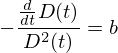

In [19]:
# Set up our function to integrate
a = sym.Symbol('a', real=True, positive=True)
fun_D = sym.Eq((1/sym.Function('D')(t)).diff(t), b)
fun_D

This is ugly, but is understood using the identity from the chain rule:  
$ {d \over dt} {1 \over x(t)} = {d \over du} {1 \over u} {du \over dt} $ where $ u = x(t) $  

Evaluating the first derivative on the RHS:  
$ {d \over du} {1 \over u} = {d \over du} {u^{-1}} = {d \over du} {-u^{-2}} = -{1 \over u^2} $  

Simplifying and substituting $ u = x(t) $:  
$ {d \over dt} {1 \over x(t)} = -{1 \over u^2} {du \over dt} = -{{du \over dt} \over u^2} = -{{d \over dt} {x(t)} \over {x(t)}^2}$

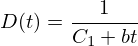

In [20]:
# Solve our function
fun_D_s = sym.dsolve(fun_D, sym.Function('D')(t))
sym.simplify(fun_D_s)

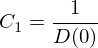

In [21]:
# Define a symbol for the constant of integration
C1 = sym.symbols('C1')

# Evaluate the constant
const = sym.Eq(C1, sym.solve(fun_D_s, C1)[0]).subs([(t, 0)])
const

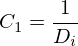

In [22]:
# Define D(0) as Di and substitute
arpsD_const = const.subs([(sym.Function('D')(0), Di)])
arpsD_const

##### 2. Using the integrate function
Next, we'll use a simpler method; the Sympy integrate function. This function does *not* produce a constant of integration, but we can easily add one ourselves.

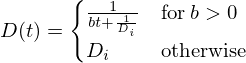

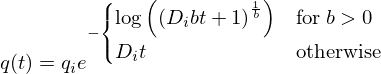

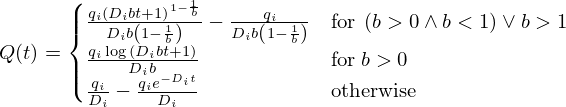

In [23]:
# Set up the symbols we will use and assumptions we can make about their values.
# As engineers, we only care about non-imaginary values!

# Derive the D(t) function. Sympy is not great at identifying singularities,
# so we help it along by defining a piecewise function at b=0.
arpsD = (1 / (sym.integrate(b, (t, 0, t)) + c)).subs([(c, 1/Di)])
arpsD = sym.Piecewise((arpsD, b>0), (arpsD.subs([(b, 0)]), True) )

# Derive the q(t) function. Logcombine simplifies our solution to force
# reduction of exp(ln(x)) to x.
arpsq = sym.integrate(arpsD, (t, 0, t))
arpsq = sym.logcombine(sym.exp(sym.log(qi) -1*(arpsq)), force=True)

# Sympy saves us a lot of effort here! Our piecewise function grows to include
# a special case when b=1.
arpscum = sym.integrate(arpsq, (t, 0, t))

#Represent these as functions for display
D_eq = sym.Eq(sym.Function('D')(t), arpsD)
q_eq = sym.Eq(sym.Function('q')(t), arpsq)
Q_eq = sym.Eq(sym.Function('Q')(t), arpscum)
display(D_eq, q_eq, Q_eq)

If we'd like to save our derivations, we can call <code>print()</code> on our objects. We can then assign the resulting output for use in future notebooks!

## Generate Production Profile
Using our symbolic derivation, we can evaluate it at discrete time points in an array. Again, the symbolic derivation has saved us the hassle of writing the $q(t)$ and $Q(t)$ functions ourselves. Generally, it would be better to import a library where these functions already exist for us than to do the derivation ourselves.

In [24]:
#Generate Data Arrays
lentime = 1200 #months, or 100 years
timearr = np.linspace(0,lentime,lentime+1)

# Define the function to apply to our time array
def set_parms(fun, time):
    parms = [(qi, 1000), (Di, .1), (b, 1.), (t, time)]
    return fun.subs(parms)

# Apply our function to the time array using list comprehension
cumprod = (365.25/12) * np.array([set_parms(arpscum, time) for time in timearr], dtype=float)

# Avg production is the first difference in cumulative production assuming time steps are unit steps in monthly time values
avgprod = np.ediff1d(cumprod, to_begin=0) / (365.12/12)

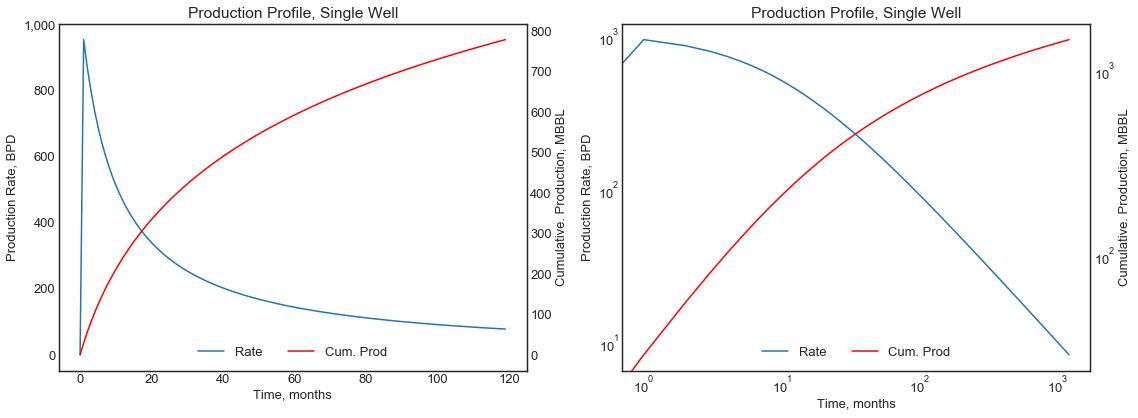

In [25]:
#Plot Production Profile
mpl.rcParams['font.size'] = 13
fig = plt.figure(figsize=(16,6))

shorttime = 120
ax1 = fig.add_subplot(121)
plot1, = ax1.plot(timearr[:shorttime], avgprod[:shorttime], label='Rate')
ax2 = ax1.twinx()
plot2, = ax2.plot(timearr[:shorttime], cumprod[:shorttime]/1000., c='r', label='Cum. Prod')
ax1.set(title='Production Profile, Single Well',
       ylabel='Production Rate, BPD',
       xlabel='Time, months')
ax2.set(ylabel='Cumulative. Production, MBBL')
ax2.legend(handles=[plot1, plot2], loc='lower center', ncol=2)
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()

ax1 = fig.add_subplot(122)
plot1, = ax1.loglog(timearr, avgprod, label='Rate')
ax2 = ax1.twinx()
plot2, = ax2.loglog(timearr, cumprod/1000., c='r', label='Cum. Prod')
ax1.set(title='Production Profile, Single Well',
       ylabel='Production Rate, BPD',
       xlabel='Time, months')
ax2.set(ylabel='Cumulative. Production, MBBL')
ax2.legend(handles=[plot1, plot2], loc='lower center', ncol=2)

plt.tight_layout()
plt.show()

## Construct a rigline
<b>Assume increasing rig count</b>
- $1{st}$ $year$: 1 well every other month
- $2{nd}$ $year$: 1 well every month
- $3{rd}$ - $6{th}$ $years$: 2 wells every month

In [26]:
#Build Rigline
pattern_yr1 = np.asarray([1.,.0])
pattern_yr2 = np.asarray([1.,1.])
pattern_yr3 = np.asarray([2.,2.])
rigline_yr1 = np.tile(pattern_yr1,6)
rigline_yr2 = np.tile(pattern_yr2,6)
rigline_yr3 = np.tile(pattern_yr3,6)
rigline_rem = np.tile(rigline_yr3,3)
rigline = np.concatenate([rigline_yr1,rigline_yr2,rigline_yr3,rigline_rem])

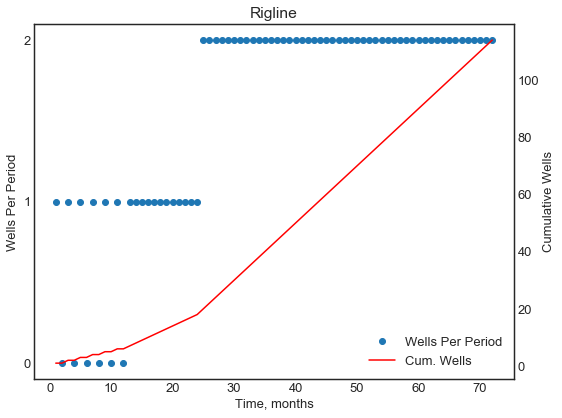

In [27]:
#Plot Rigline
mpl.rcParams['font.size'] = 13
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.plot(np.arange(6*12)+1,rigline, ls='none', marker='o', label='Wells Per Period')
ax2 = ax1.twinx()
ax2.plot(np.arange(6*12)+1,np.cumsum(rigline), color='r', label='Cum. Wells')
ax1.set(title='Rigline',
       ylabel='Wells Per Period',
       xlabel='Time, months',
       yticks=([0, 1, 2]))
ax2.set(ylabel='Cumulative Wells')
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend([*h1, *h2], [*l1, *l2], loc='lower right', ncol=1)

plt.tight_layout()
plt.show()

# Magic Happens Here
Here is where we build the growth profile. The convolution integral is:<br/>
$$
x(t)=\int_{0}^{t}{f(\tau) g^\prime (t - \tau) d\tau}
$$  

Or in plain terms, $f(t)$ is our production profile (or any other profile!), and $g(t)$ is the # of wells in the period.  

In [28]:
# Convolve Profiles with Rigline

riglinecumprod = conv(cumprod, rigline)
riglineavgprod = np.ediff1d(riglinecumprod, to_begin=0) / (365.25/12)

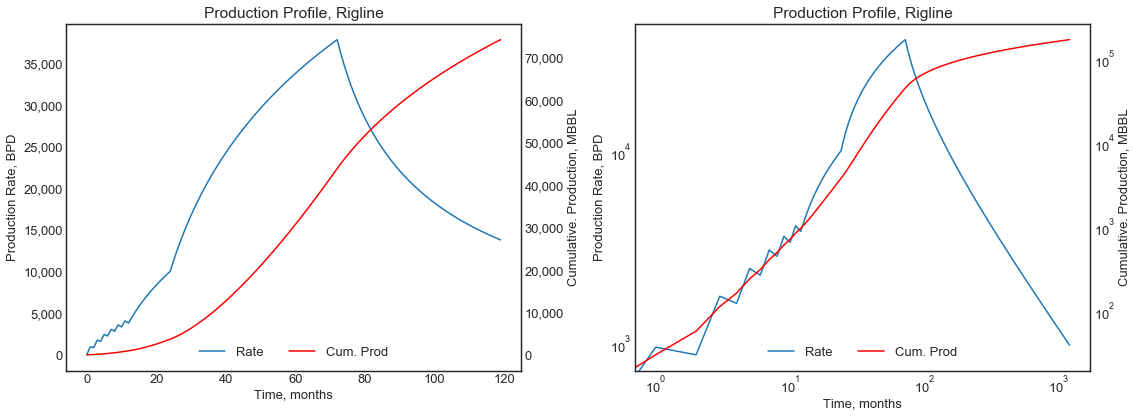

In [29]:
mpl.rcParams['font.size'] = 13
fig = plt.figure(figsize=(16,6))

#Plot small number of months
ax1 = fig.add_subplot(121)
plot1, = ax1.plot(timearr[:shorttime], riglineavgprod[:shorttime], label='Rate')
ax2 = ax1.twinx()
plot2, = ax2.plot(timearr[:shorttime], riglinecumprod[:shorttime]/1000., c='r', label='Cum. Prod')
ax1.set(title='Production Profile, Rigline',
       ylabel='Production Rate, BPD',
       xlabel='Time, months')
ax2.set(ylabel='Cumulative. Production, MBBL')
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.legend(handles=[plot1, plot2], loc='lower center', ncol=2)

#Plot full time array
ax1 = fig.add_subplot(122)
plot1, = ax1.loglog(timearr, riglineavgprod, label='Rate')
ax2 = ax1.twinx()
plot2, = ax2.loglog(timearr, riglinecumprod/1000., c='r', label='Cum. Prod')
ax1.set(title='Production Profile, Rigline',
       ylabel='Production Rate, BPD',
       xlabel='Time, months')
ax2.set(ylabel='Cumulative. Production, MBBL')
ax2.legend(handles=[plot1, plot2], loc='lower center', ncol=2)

plt.tight_layout()
plt.show()

##### And voila!

What if the type well profile varies? Well, in that case we would simply convolve each type well profile with the schedules of wells to which that type well is assigned.

Simple risking can be accounted for by factoring the wellcount, e.g. if we assign a $P_C$ of 95% as one might do in ARIES®, PHDWin®, PEEP®, ValNav®, or other software.

Let's assume we asign a $P_c$ of 95% to all wells, and then a performance scalar, accounting for drilling non-core areas in year three, of 90%.

In [30]:
#Build Rigline

Pc = 0.95
perf_factor = 0.75

pattern_yr1 = Pc * np.asarray([1.,.0])
pattern_yr2 = Pc * np.asarray([1.,1.])
pattern_yr3 = Pc * perf_factor * np.asarray([2.,2.])
rigline_yr1 = np.tile(pattern_yr1,6)
rigline_yr2 = np.tile(pattern_yr2,6)
rigline_yr3 = np.tile(pattern_yr3,6)
rigline_rem = np.tile(rigline_yr3,3)
rigline_adj = np.concatenate([rigline_yr1,rigline_yr2,rigline_yr3,rigline_rem])

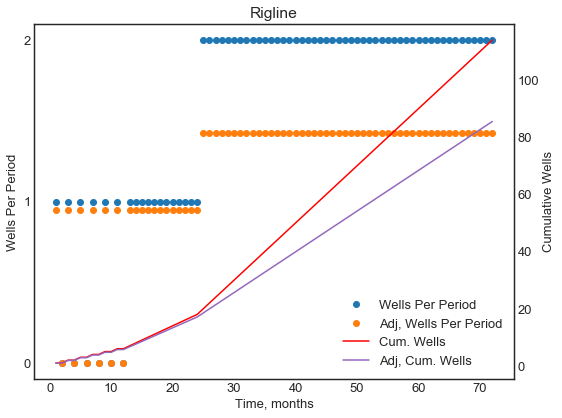

In [31]:
#Plot Rigline
mpl.rcParams['font.size'] = 13
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.plot(np.arange(6*12)+1,rigline, ls='none', marker='o', label='Wells Per Period')
ax2 = ax1.twinx()
ax2.plot(np.arange(6*12)+1,np.cumsum(rigline), color='r', label='Cum. Wells')

ax1.plot(np.arange(6*12)+1,rigline_adj, ls='none', marker='o', label='Adj, Wells Per Period')
ax2.plot(np.arange(6*12)+1,np.cumsum(rigline_adj), color='C4', label='Adj, Cum. Wells')

ax1.set(title='Rigline',
       ylabel='Wells Per Period',
       xlabel='Time, months',
       yticks=([0, 1, 2]))
ax2.set(ylabel='Cumulative Wells')
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend([*h1, *h2], [*l1, *l2], loc='lower right', ncol=1)

plt.tight_layout()
plt.show()

In [32]:
# Convolve Profiles with Rigline

riglinecumprod_adj = conv(cumprod, rigline_adj)
riglineavgprod_adj = np.ediff1d(riglinecumprod_adj, to_begin=0) / (365.25/12)

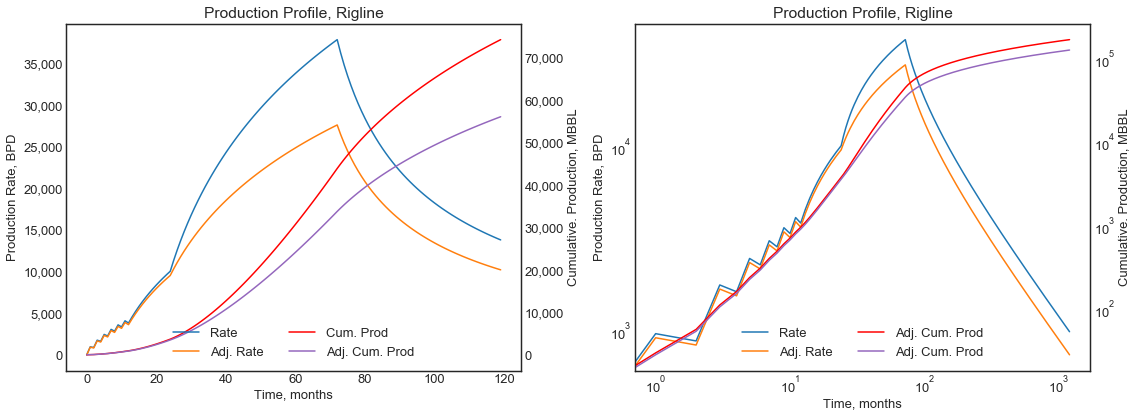

In [33]:
mpl.rcParams['font.size'] = 13
fig = plt.figure(figsize=(16,6))

#Plot small number of months
ax1 = fig.add_subplot(121)
ax1.plot(timearr[:shorttime], riglineavgprod[:shorttime], label='Rate')
ax1.plot(timearr[:shorttime], riglineavgprod_adj[:shorttime], label='Adj. Rate')

ax2 = ax1.twinx()
ax2.plot(timearr[:shorttime], riglinecumprod[:shorttime]/1000., c='r', label='Cum. Prod')
ax2.plot(timearr[:shorttime], riglinecumprod_adj[:shorttime]/1000., c='C4', label='Adj. Cum. Prod')

ax1.set(title='Production Profile, Rigline',
       ylabel='Production Rate, BPD',
       xlabel='Time, months')
ax2.set(ylabel='Cumulative. Production, MBBL')
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend([*h1, *h2], [*l1, *l2], loc='lower center', ncol=2)

#Plot full time array
ax1 = fig.add_subplot(122)
ax1.loglog(timearr, riglineavgprod, label='Rate')
ax1.loglog(timearr, riglineavgprod_adj, label='Adj. Rate')

ax2 = ax1.twinx()
ax2.loglog(timearr, riglinecumprod/1000., c='r', label='Adj. Cum. Prod')
ax2.loglog(timearr, riglinecumprod_adj/1000., c='C4', label='Adj. Cum. Prod')

ax1.set(title='Production Profile, Rigline',
       ylabel='Production Rate, BPD',
       xlabel='Time, months')
ax2.set(ylabel='Cumulative. Production, MBBL')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend([*h1, *h2], [*l1, *l2], loc='lower center', ncol=2)

plt.tight_layout()
plt.show()

Hope this has been interesting!